# K-Nearest Neighbors Classifier

In [1]:
import pickle

X_test = pickle.load( open( "../data/X_test.p", "rb" ) )
X_train = pickle.load( open( "../data/X_train.p", "rb" ) )
y_test = pickle.load( open( "../data/y_test.p", "rb" ) )
y_train = pickle.load( open( "../data/y_train.p", "rb" ) )
data = pickle.load( open( "../data/encodings_final.p", "rb"))

type(y_train)
y_train.to_numpy()
#y_train = y_train.values.ravel()

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Imbalance of the readmission variable

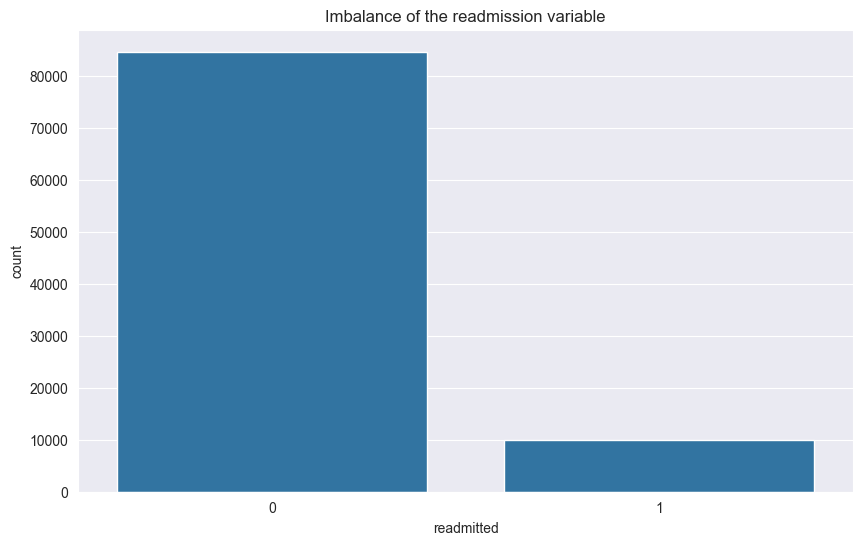

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x='readmitted', data=data)
plt.title('Imbalance of the readmission variable')
plt.show()

## Normal KNN

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
print(y_train.values.ravel())
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

[0 0 1 ... 0 0 0]
Confusion Matrix:


ValueError: Classification metrics can't handle a mix of unknown and binary targets

## Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train.values.ravel())

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_oversampled.value_counts())

### k-NN with oversampling

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_oversampled, y_train_oversampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

## Undersampling with RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print("Before undersampling:")
print(y_train['readmitted'].value_counts())
print("\nAfter undersampling:")
print(y_train_undersampled['readmitted'].value_counts())

### k-NN with undersampling

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=33, metric="manhattan", weights="distance")

knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax = ax)

# Hyperparameter tuning

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

k_values = range(1, 31)

f1_scores_oversampling_train = []
f1_scores_undersampling_train = []
f1_scores_oversampling_test = []
f1_scores_undersampling_test = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # oversampling
    knn.fit(X_train_oversampled, y_train_oversampled.values.ravel())
    y_pred_oversampling_train = knn.predict(X_train_oversampled)
    y_pred_oversampling_test = knn.predict(X_test)
    f1_scores_oversampling_train.append(f1_score(y_train_oversampled, y_pred_oversampling_train))
    f1_scores_oversampling_test.append(f1_score(y_test, y_pred_oversampling_test))

    # undersampling
    knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
    y_pred_undersampling_train = knn.predict(X_train_undersampled)
    y_pred_undersampling_test = knn.predict(X_test)
    f1_scores_undersampling_train.append(f1_score(y_train_undersampled, y_pred_undersampling_train))
    f1_scores_undersampling_test.append(f1_score(y_test, y_pred_undersampling_test))

# Plot the F1 scores
plt.figure(figsize=(10, 6))

# Oversampling scores
plt.plot(k_values, f1_scores_oversampling_train, label='Oversampled Data - Train')
plt.plot(k_values, f1_scores_oversampling_test, label='Oversampled Data - Test')

# Undersampling scores
plt.plot(k_values, f1_scores_undersampling_train, label='Undersampled Data - Train')
plt.plot(k_values, f1_scores_undersampling_test, label='Undersampled Data - Test')

plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score of KNN for different values of k')
plt.legend()
plt.show()

## using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameters
hyperparameters = {'n_neighbors': [17, 19, 21, 23, 25, 27, 29, 31, 33 ], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, hyperparameters, cv=5)
clf.fit(X_train_undersampled, y_train_undersampled.values.ravel())

print("Best Parameters: ", clf.best_params_)
print("Best cvs score (accuracy): ", clf.best_score_)

In [ ]:
from sklearn.metrics import make_scorer, recall_score

hyperparameters = {'n_neighbors': list(range(1, 41)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()

def recall_optim(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    rec = recall_score(y_true, y_pred) * 0.8
    spe = cm[0,0]/cm[0,:].sum() * 0.2
    if rec < 0.8:
        rec -= 0.2
    return rec + spe

optimize = make_scorer(recall_optim)

clf = GridSearchCV(knn, hyperparameters, cv=5, scoring=optimize)
clf.fit(X_train_undersampled, y_train_undersampled.values.ravel())

print("Best Parameters: ", clf.best_params_)
print("Best cvs score (optimized recall): ", clf.best_score_)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=24, metric="euclidean", weights="distance")

knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax = ax)